# This code is for the multimodal inference using SEEG and EEG simulataneously (HMC algorihtm)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import subprocess
import pandas as pd
import os.path as op

sys.path.append('/root/capsule/code/vep/core')
sys.path.append('/root/capsule/code/vep/stan')
import vep_prepare_op
import vep_mcmc
import analyze_fit
import stan

## Compute data features

In [10]:
# define parameters
pid = 'Patient2'
basicfilename2 = 'P2_SEEG_EEG_fit'
basicfilename1 = 'P2_SEEG_ts_fit'
mcmc_fit_id = 'fit_SEEG_multimodal'


# parameters to compute the 50 estimations, using stan optimize
n_optimize = 50 # number of optimization
n_optimize_jobs = 50 # number of optimization jobs to be run in parallel

# parameters to select the best estimations to create R files containing initial values for MCMC chains
n_best = 8

# parameters for MCMC
n_chains_per_init = 2 # number of chains to run for each set of initial values
n_sample_jobs = 16 # number of chains jobs to be run in parallel

In [11]:
data_sim_folder = f'/data/dataSim/{pid}'
#subj_raw_dir  = f'{data_sim_folder}/func/'
results_dir = f'/results/sampling/{pid}'
os.makedirs(f'{results_dir}', exist_ok=True)
#basicfilename = f'{pid}_seizure_run01_seeg'



In [12]:
vhdrname_1 = f'{data_sim_folder}/{basicfilename1}.npz'
vhdrname_2 = f'{data_sim_folder}/{basicfilename2}.npz'

In [13]:
data_sim_1 = np.load(vhdrname_1)
data_sim_2 = np.load(vhdrname_2)
gain_1=data_sim_1['gain']
gain_2=data_sim_2['gain']
tts_1 = data_sim_1['time_steps']
tts_2 = data_sim_2['time_steps']
seeg = data_sim_1['seeg']
eeg = data_sim_2['eeg']
#to change
SC = data_sim_1['SC']
np.fill_diagonal(SC, np.diag(SC) - SC.sum(axis=1))
ch_names_1 = data_sim_1['ch_names']

In [14]:
print(np.shape(gain_1))
print(np.shape(gain_2))

(191, 162)
(128, 162)


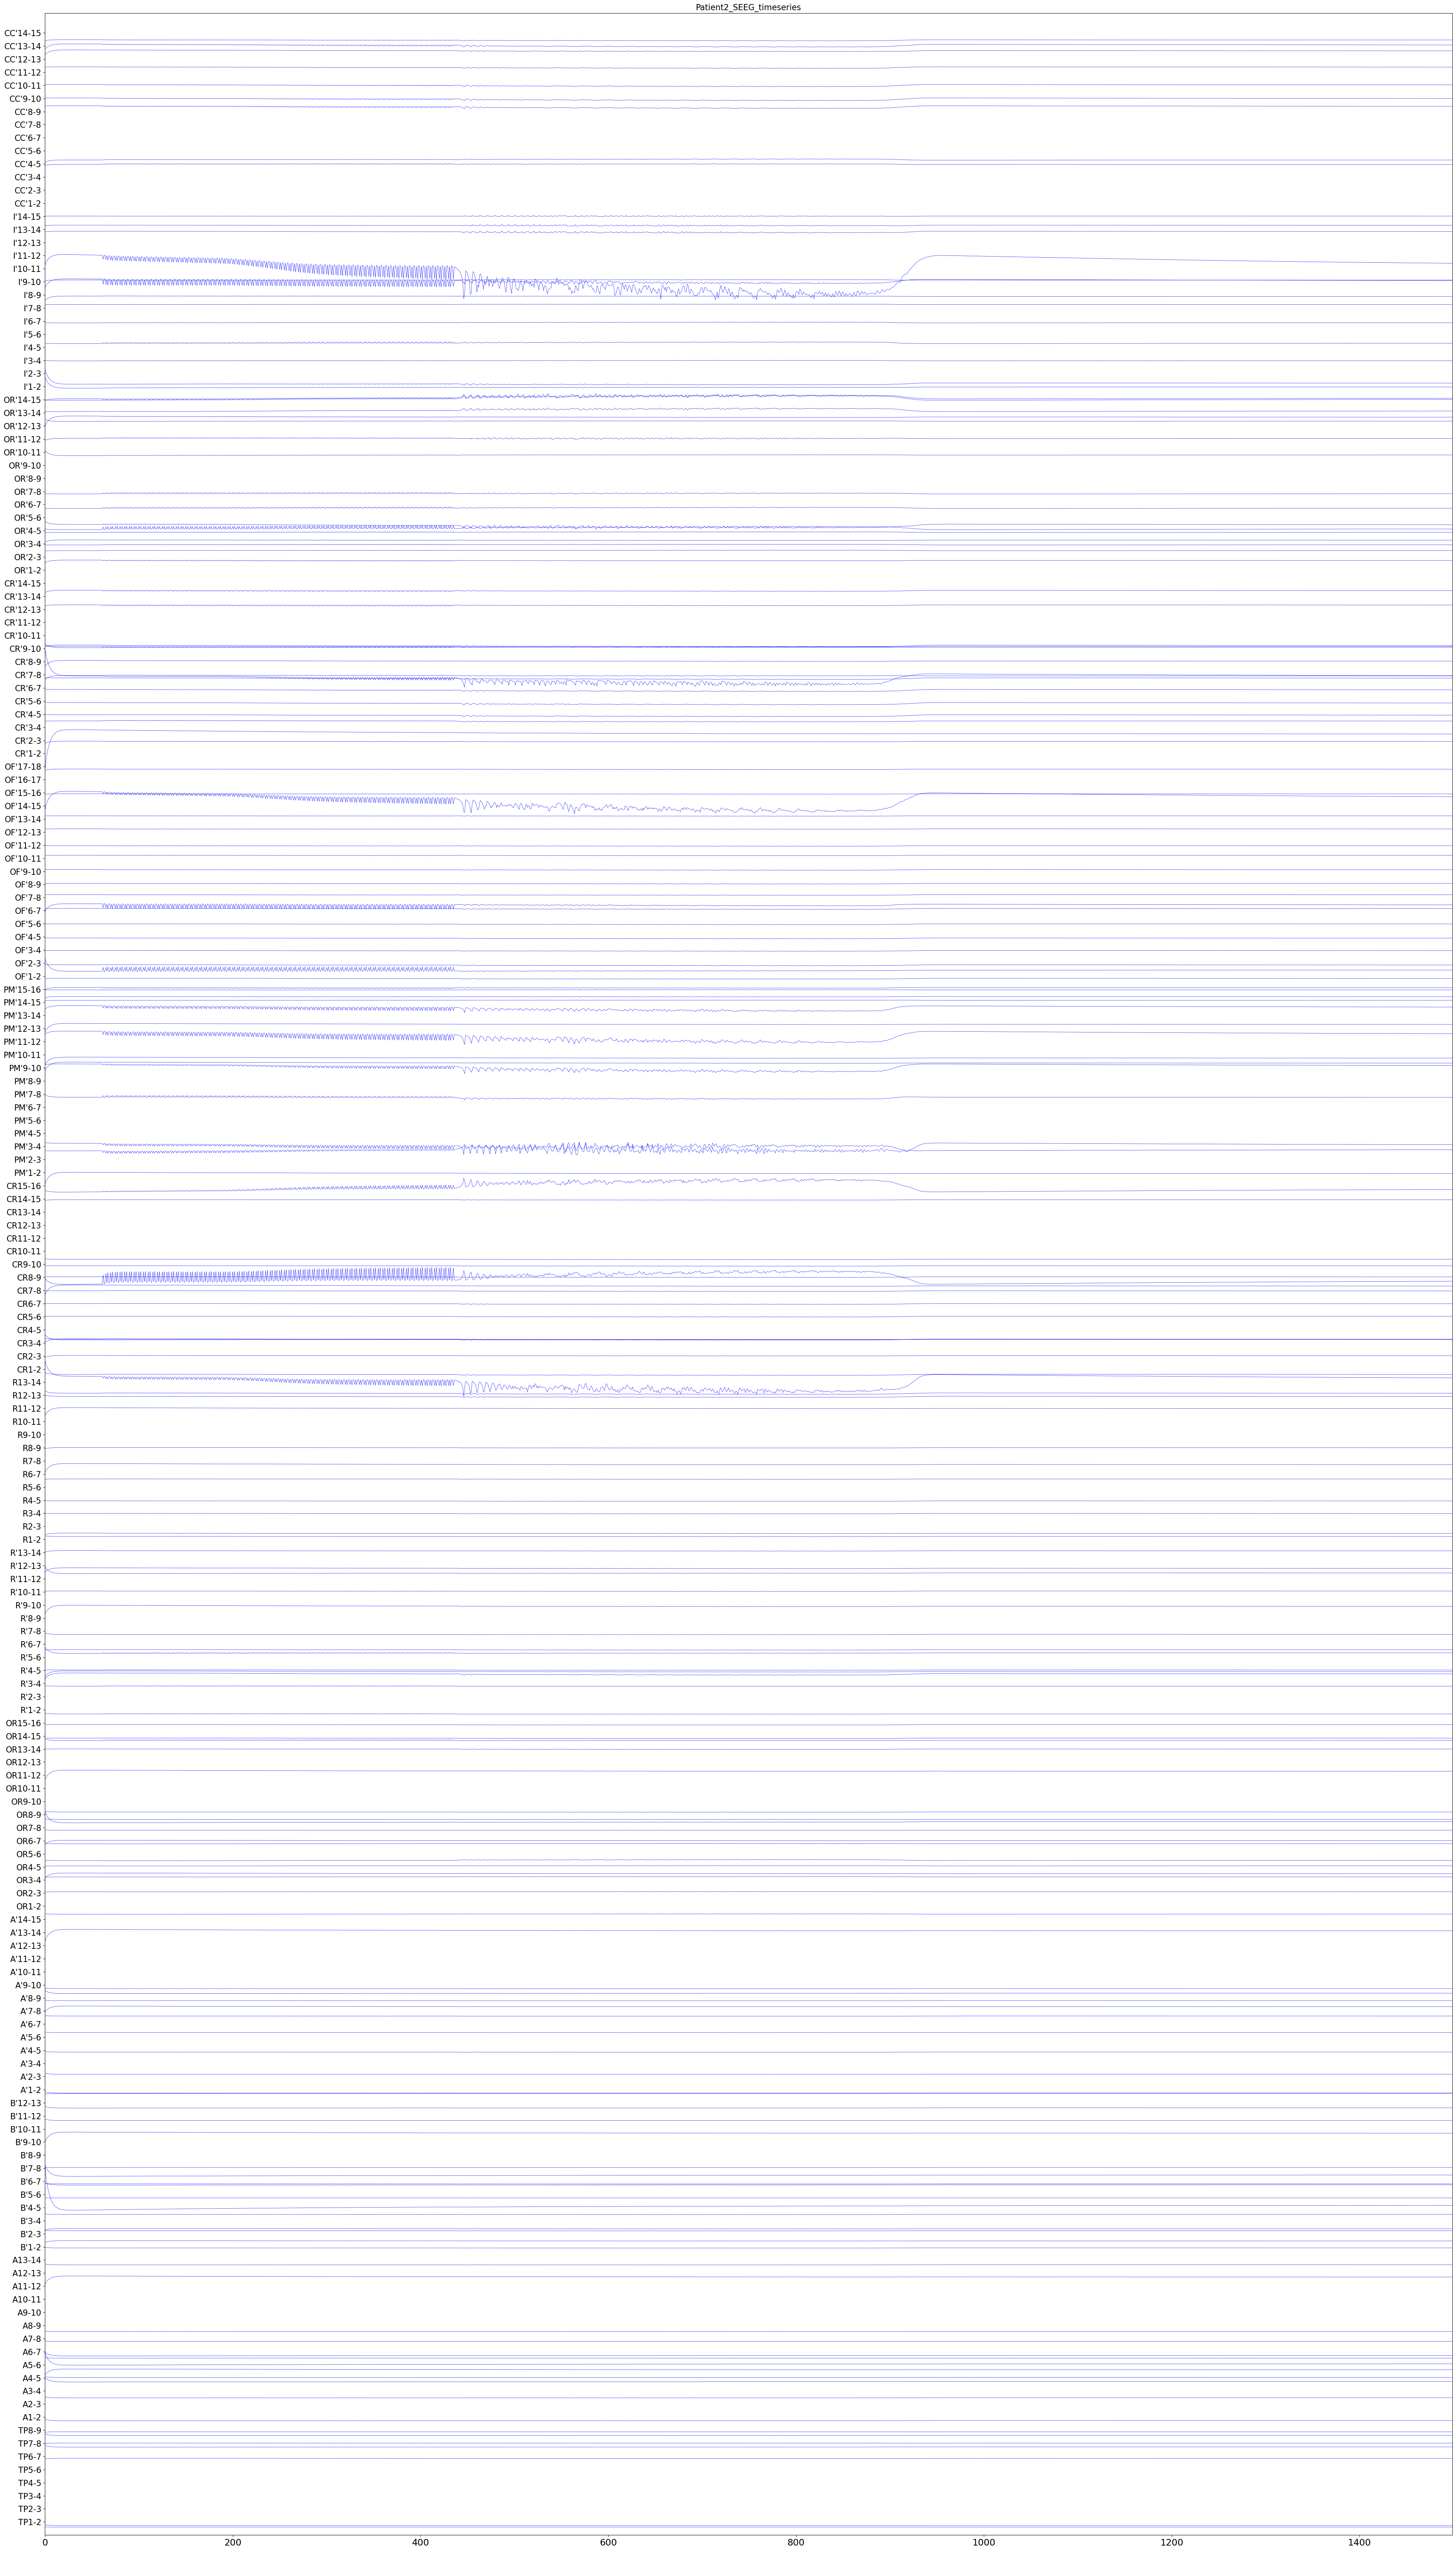

In [17]:
# plot real data at sensor level
title = f"{pid}_SEEG_timeseries"
show_ch_1 = ch_names_1
#show_ch_2 = ch_names_2

nch_source_1 = show_ch_1
#nch_source_2 = show_ch_2

#SEEG
figsize = [40,70]    
y = seeg
t = np.arange(len(tts_1))
data_scaleplt = 10

f = plt.figure(figsize=figsize)

ch_selection = range(len(show_ch_1))
for ch_offset, ch_ind in enumerate(ch_selection):
    plt.plot(t, data_scaleplt*y[ch_ind]+ch_offset, 'blue', lw=0.5)
        
plt.xticks(fontsize=18)
plt.xlim([t[0],t[-1]])
plt.yticks(range(len(ch_selection)), [nch_source_1[ch_index] for ch_index in ch_selection], fontsize=16)
plt.ylim([-1,len(ch_selection)+0.5])

plt.title(title,fontsize = 16)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.97)
plt.tight_layout()


In [18]:
nchan, nt = np.shape(eeg)
show_ch_2 = [f'E{ic}' for ic in np.arange(nchan)]

In [19]:
from scipy import signal
import matplotlib.pyplot as plt

In [20]:
import vep_prepare_op

sfreq_1 =250.
IND_ON_1 = 440
IND_OFF_1 = 1100
IND_BD_1 = 200
Nsamp_1 = 0.02


#seeg_4feature = -(seeg[:,IND_ON:IND_OFF] - seeg[:,IND_ON:IND_OFF].mean(axis=0)) # + numpy.random.normal(0, Nsamp, size=len(seeg[:,IND_ON:IND_OFF].T))
#seeg_4feature = np.concatenate([numpy.random.normal(0, Nsamp, size=[len(seeg), IND_BD]), seeg_4feature,numpy.random.normal(0, Nsamp, size=[len(seeg), IND_BD])],axis = 1) 
# this part is for stimulated-NF data
seeg_4feature_1 = np.concatenate([seeg[:,IND_OFF_1:(IND_OFF_1+IND_BD_1)],seeg[:,IND_ON_1:IND_OFF_1+IND_BD_1]],axis = 1) 
seeg_4feature_1 = seeg_4feature_1.T - seeg[:,IND_OFF_1:(IND_OFF_1+IND_BD_1)].T.mean(axis=0)

hpf_1 = 4.
lpf_1 = 1.
data_1 = vep_prepare_op.prepare_data_feature_op(SC, seeg_4feature_1,gain_1, sfreq_1, hpf_1, lpf_1)


# this part is for stimulated-NF data
colorSLP = np.max(data_1['slp'][:100,:], axis = 0) > -12.4
offset_normal_1 = -20
data_df_1 = data_1['slp'].copy()
for inS, incolor in enumerate(colorSLP):
    if incolor == False: 
        data_df_1[:,inS] = np.ones(np.shape(data_1['slp'][:,0]))*offset_normal_1
df_normal_1 = (data_df_1-offset_normal_1)/np.max(np.abs(data_df_1-offset_normal_1))
thresholdmin = 0.002
df_normal_1[df_normal_1<thresholdmin] = thresholdmin

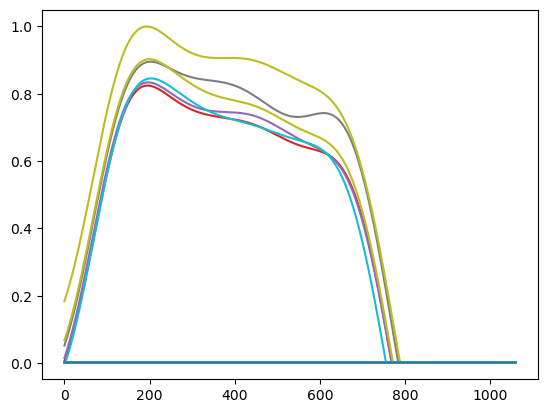

In [21]:
plt.plot(df_normal_1);

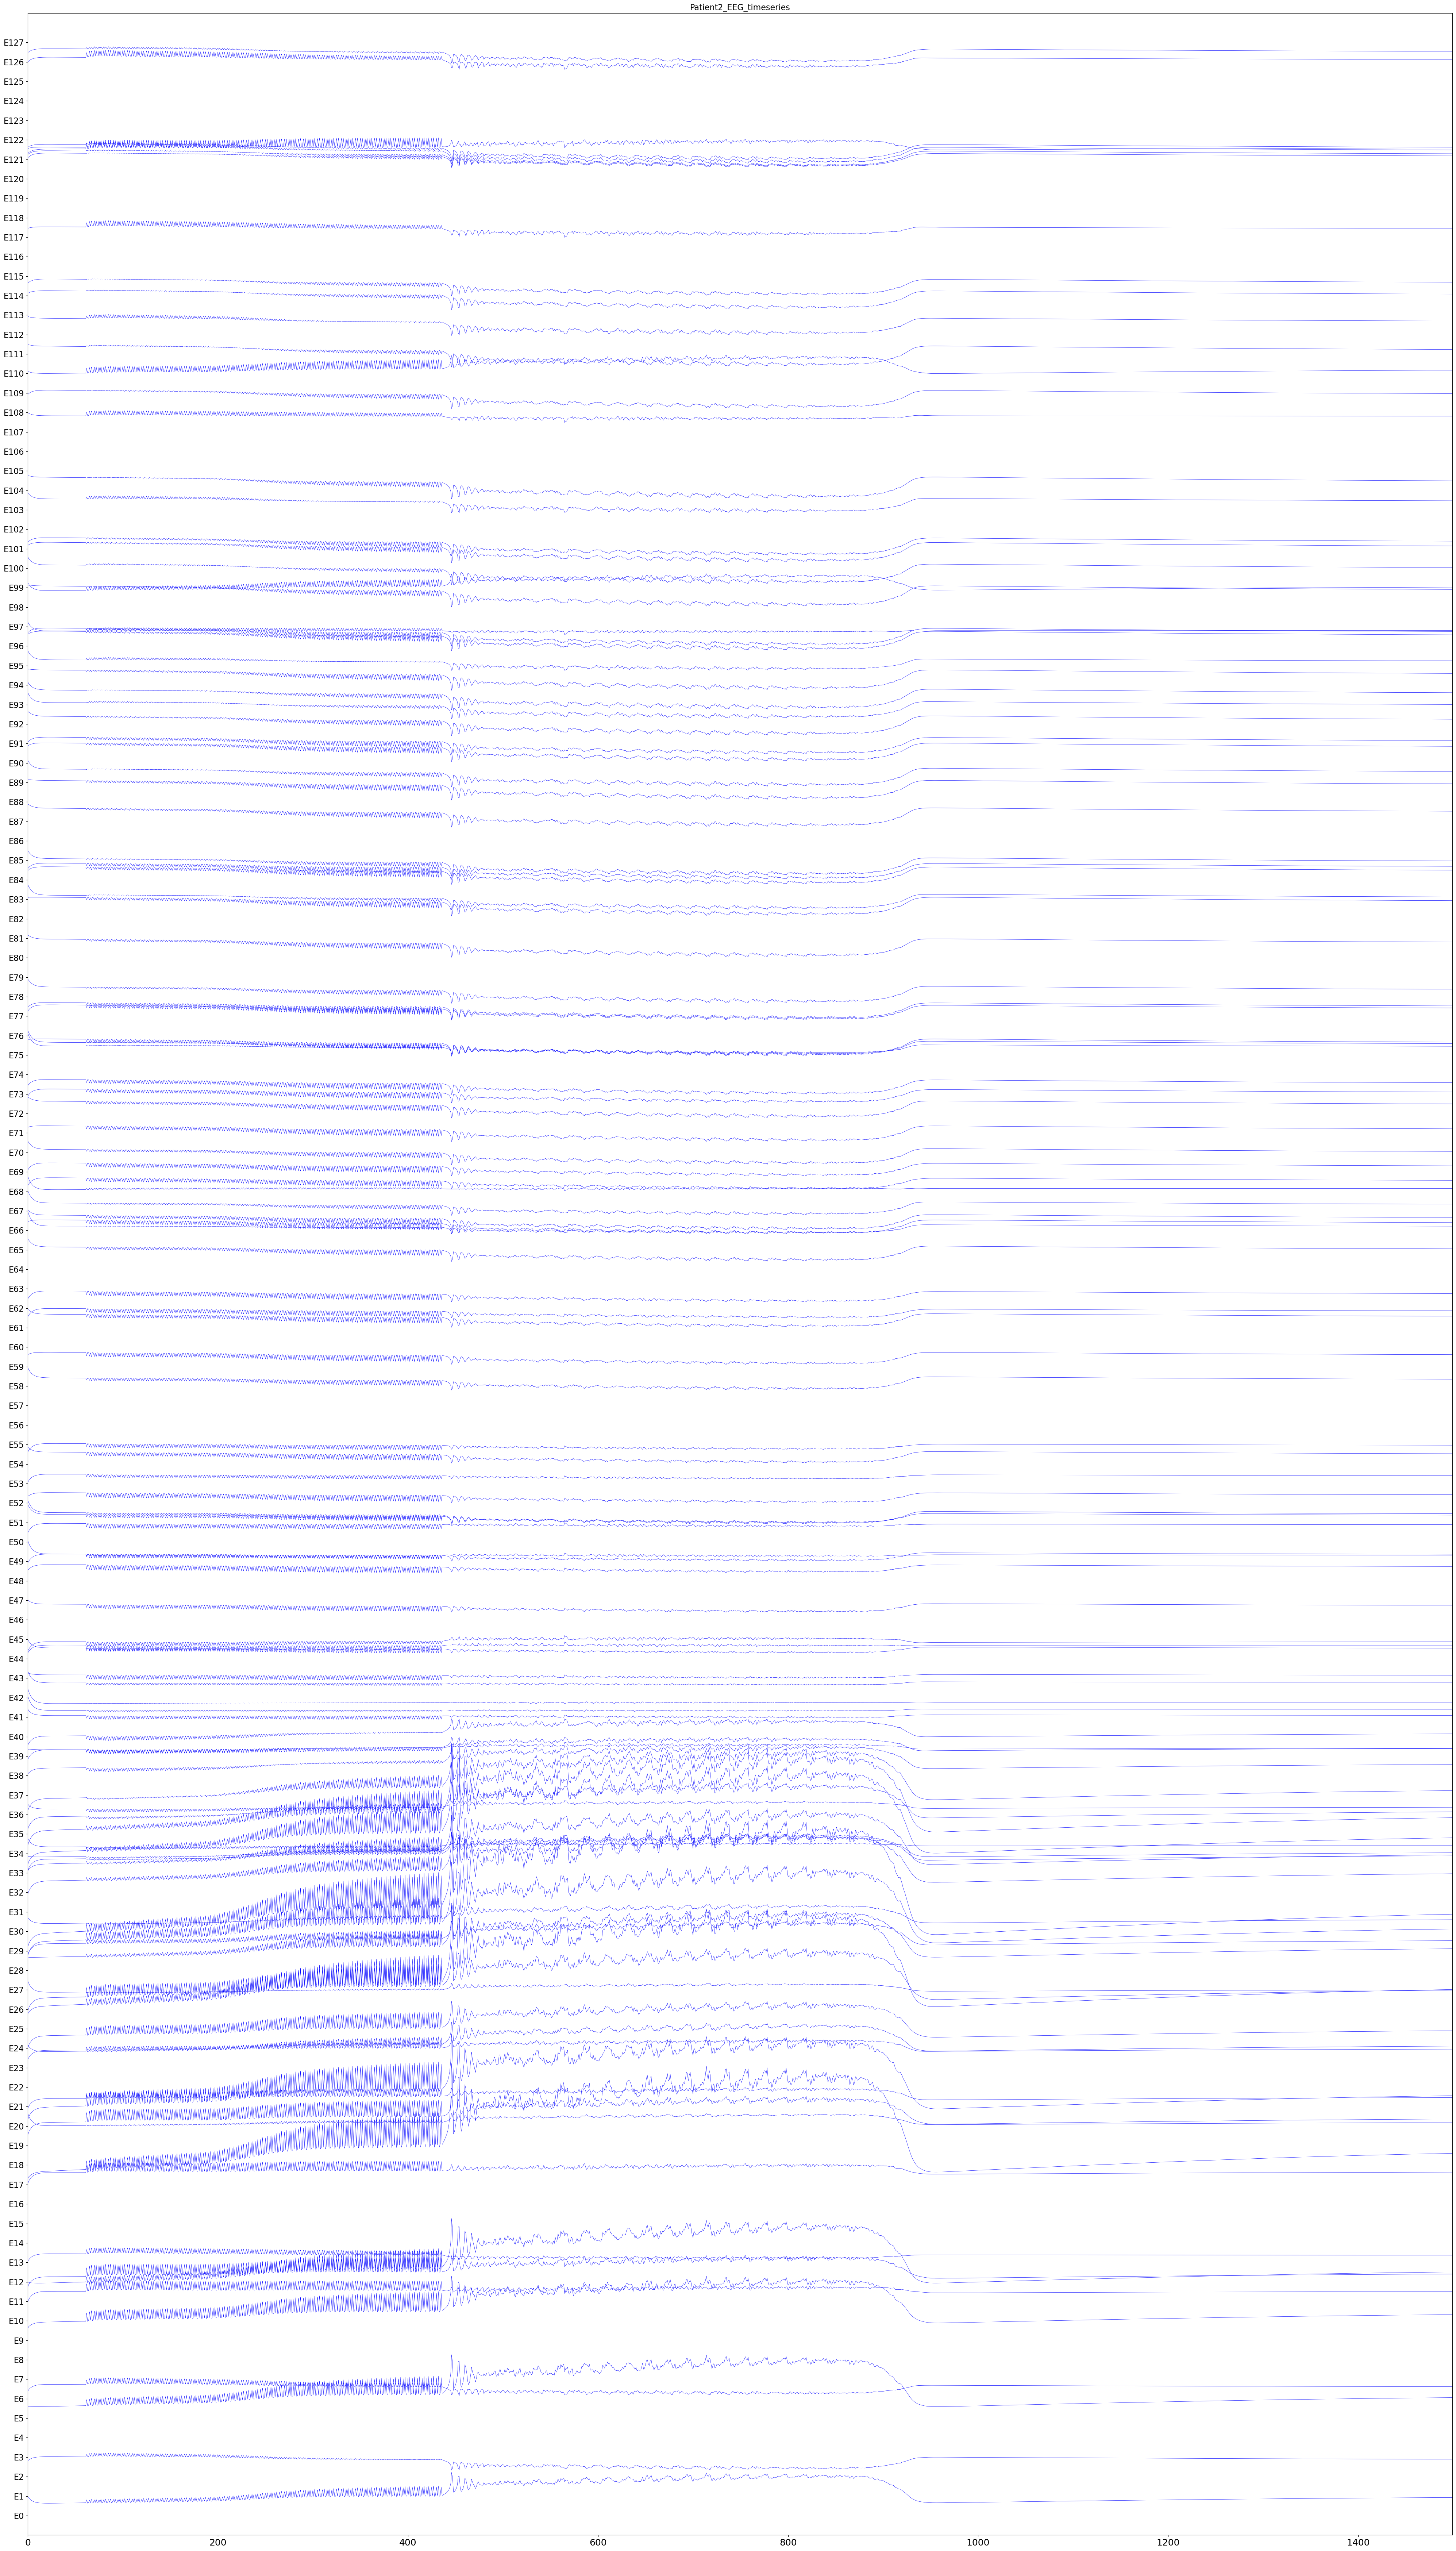

In [22]:
#EEG
figsize = [40,70]    
y = eeg
t = np.arange(len(tts_2))
data_scaleplt = 0.0002

f = plt.figure(figsize=figsize)

ch_selection = range(len(show_ch_2))
for ch_offset, ch_ind in enumerate(ch_selection):
    plt.plot(t, data_scaleplt*y[ch_ind]+ch_offset, 'blue', lw=0.5)
        
plt.xticks(fontsize=18)
plt.xlim([t[0],t[-1]])
plt.yticks(range(len(ch_selection)), [show_ch_2[ch_index] for ch_index in ch_selection], fontsize=16)
plt.ylim([-1,len(ch_selection)+0.5])

plt.title(f"{pid}_EEG_timeseries",fontsize = 16)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.97)
plt.tight_layout()

In [23]:
#EEG
sfreq_2 =250.
IND_ON_2 = 440
IND_OFF_2 = 1100
IND_BD_2 = 200
Nsamp_2 = 0.02
seeg_4feature_2 = np.concatenate([eeg[:,IND_OFF_2:(IND_OFF_2+IND_BD_2)],eeg[:,IND_ON_2:IND_OFF_2+IND_BD_2]],axis = 1) 
seeg_4feature_2 = seeg_4feature_2.T #- seeg[:,0]

hpf_2 = 10.
lpf_2 = 1.5
data_2 = vep_prepare_op.prepare_data_feature_op(SC, seeg_4feature_2,gain_2, sfreq_2, hpf_2, lpf_2)

nn,nt = np.shape(data_2['slp'].T)
df_normal_baseline = np.ones([1,nt])

data_df_2 = data_2['slp'].T
eeg_seizure_2 = eeg[:,IND_ON_2:IND_OFF_2];
for ind_eeg in np.arange(128):
    if np.ptp(eeg_seizure_2[ind_eeg,200:400]) < 5000:
        data_df_2[ind_eeg] = df_normal_baseline

offset_normal_2 = 0.
df_normal_2 = (data_df_2-offset_normal_2)/np.max(np.abs(data_df_2-offset_normal_2))
thredshod = np.mean(df_normal_baseline)/np.max(np.abs(data_df_2-offset_normal_2))
df_normal_2[df_normal_2< thredshod] = thredshod

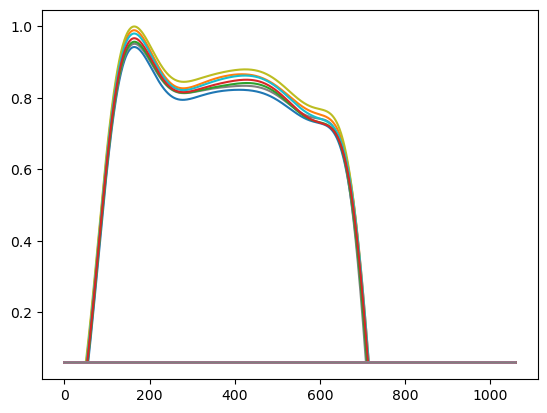

In [24]:
plt.plot(df_normal_2.T);

In [26]:
def datafeatures__rpne_039__fname_EEG_SEEG(vhdr_fname_1,vhdr_fname_2, mcmc_fit_id, subj_proc_dir, hpf_1, lpf_1,hpf_2, lpf_2):
    bname = op.basename(vhdr_fname_1).rstrip('_ieeg.vhdr')
    bname +=op.basename(vhdr_fname_2).rstrip('_ieeg.vhdr')
    bname += f'_SEEG_hpf{hpf_1}_lpf{lpf_1}_'
    bname += f'EEG_hpf{hpf_2}_lpf{lpf_2}__datafeatures.R'
    fname = op.join(vep_mcmc.mcmc__dname(subj_proc_dir=subj_proc_dir, mcmc_fit_id=mcmc_fit_id), 'vep_dfs', bname)
    return fname




basicfilename_1 = vhdrname_1
basicfilename_2 = vhdrname_2
datafeatures_fname = datafeatures__rpne_039__fname_EEG_SEEG(vhdr_fname_1=basicfilename_1,
                                                                       vhdr_fname_2=basicfilename_2,
                                                                       mcmc_fit_id=mcmc_fit_id,
                                                                       subj_proc_dir=results_dir,
                                                                       hpf_1=hpf_1, lpf_1=lpf_1,
                                                                        hpf_2=hpf_2, lpf_2=lpf_2)

>> Save /results/sampling/Patient2/00_Patient2_SC.png


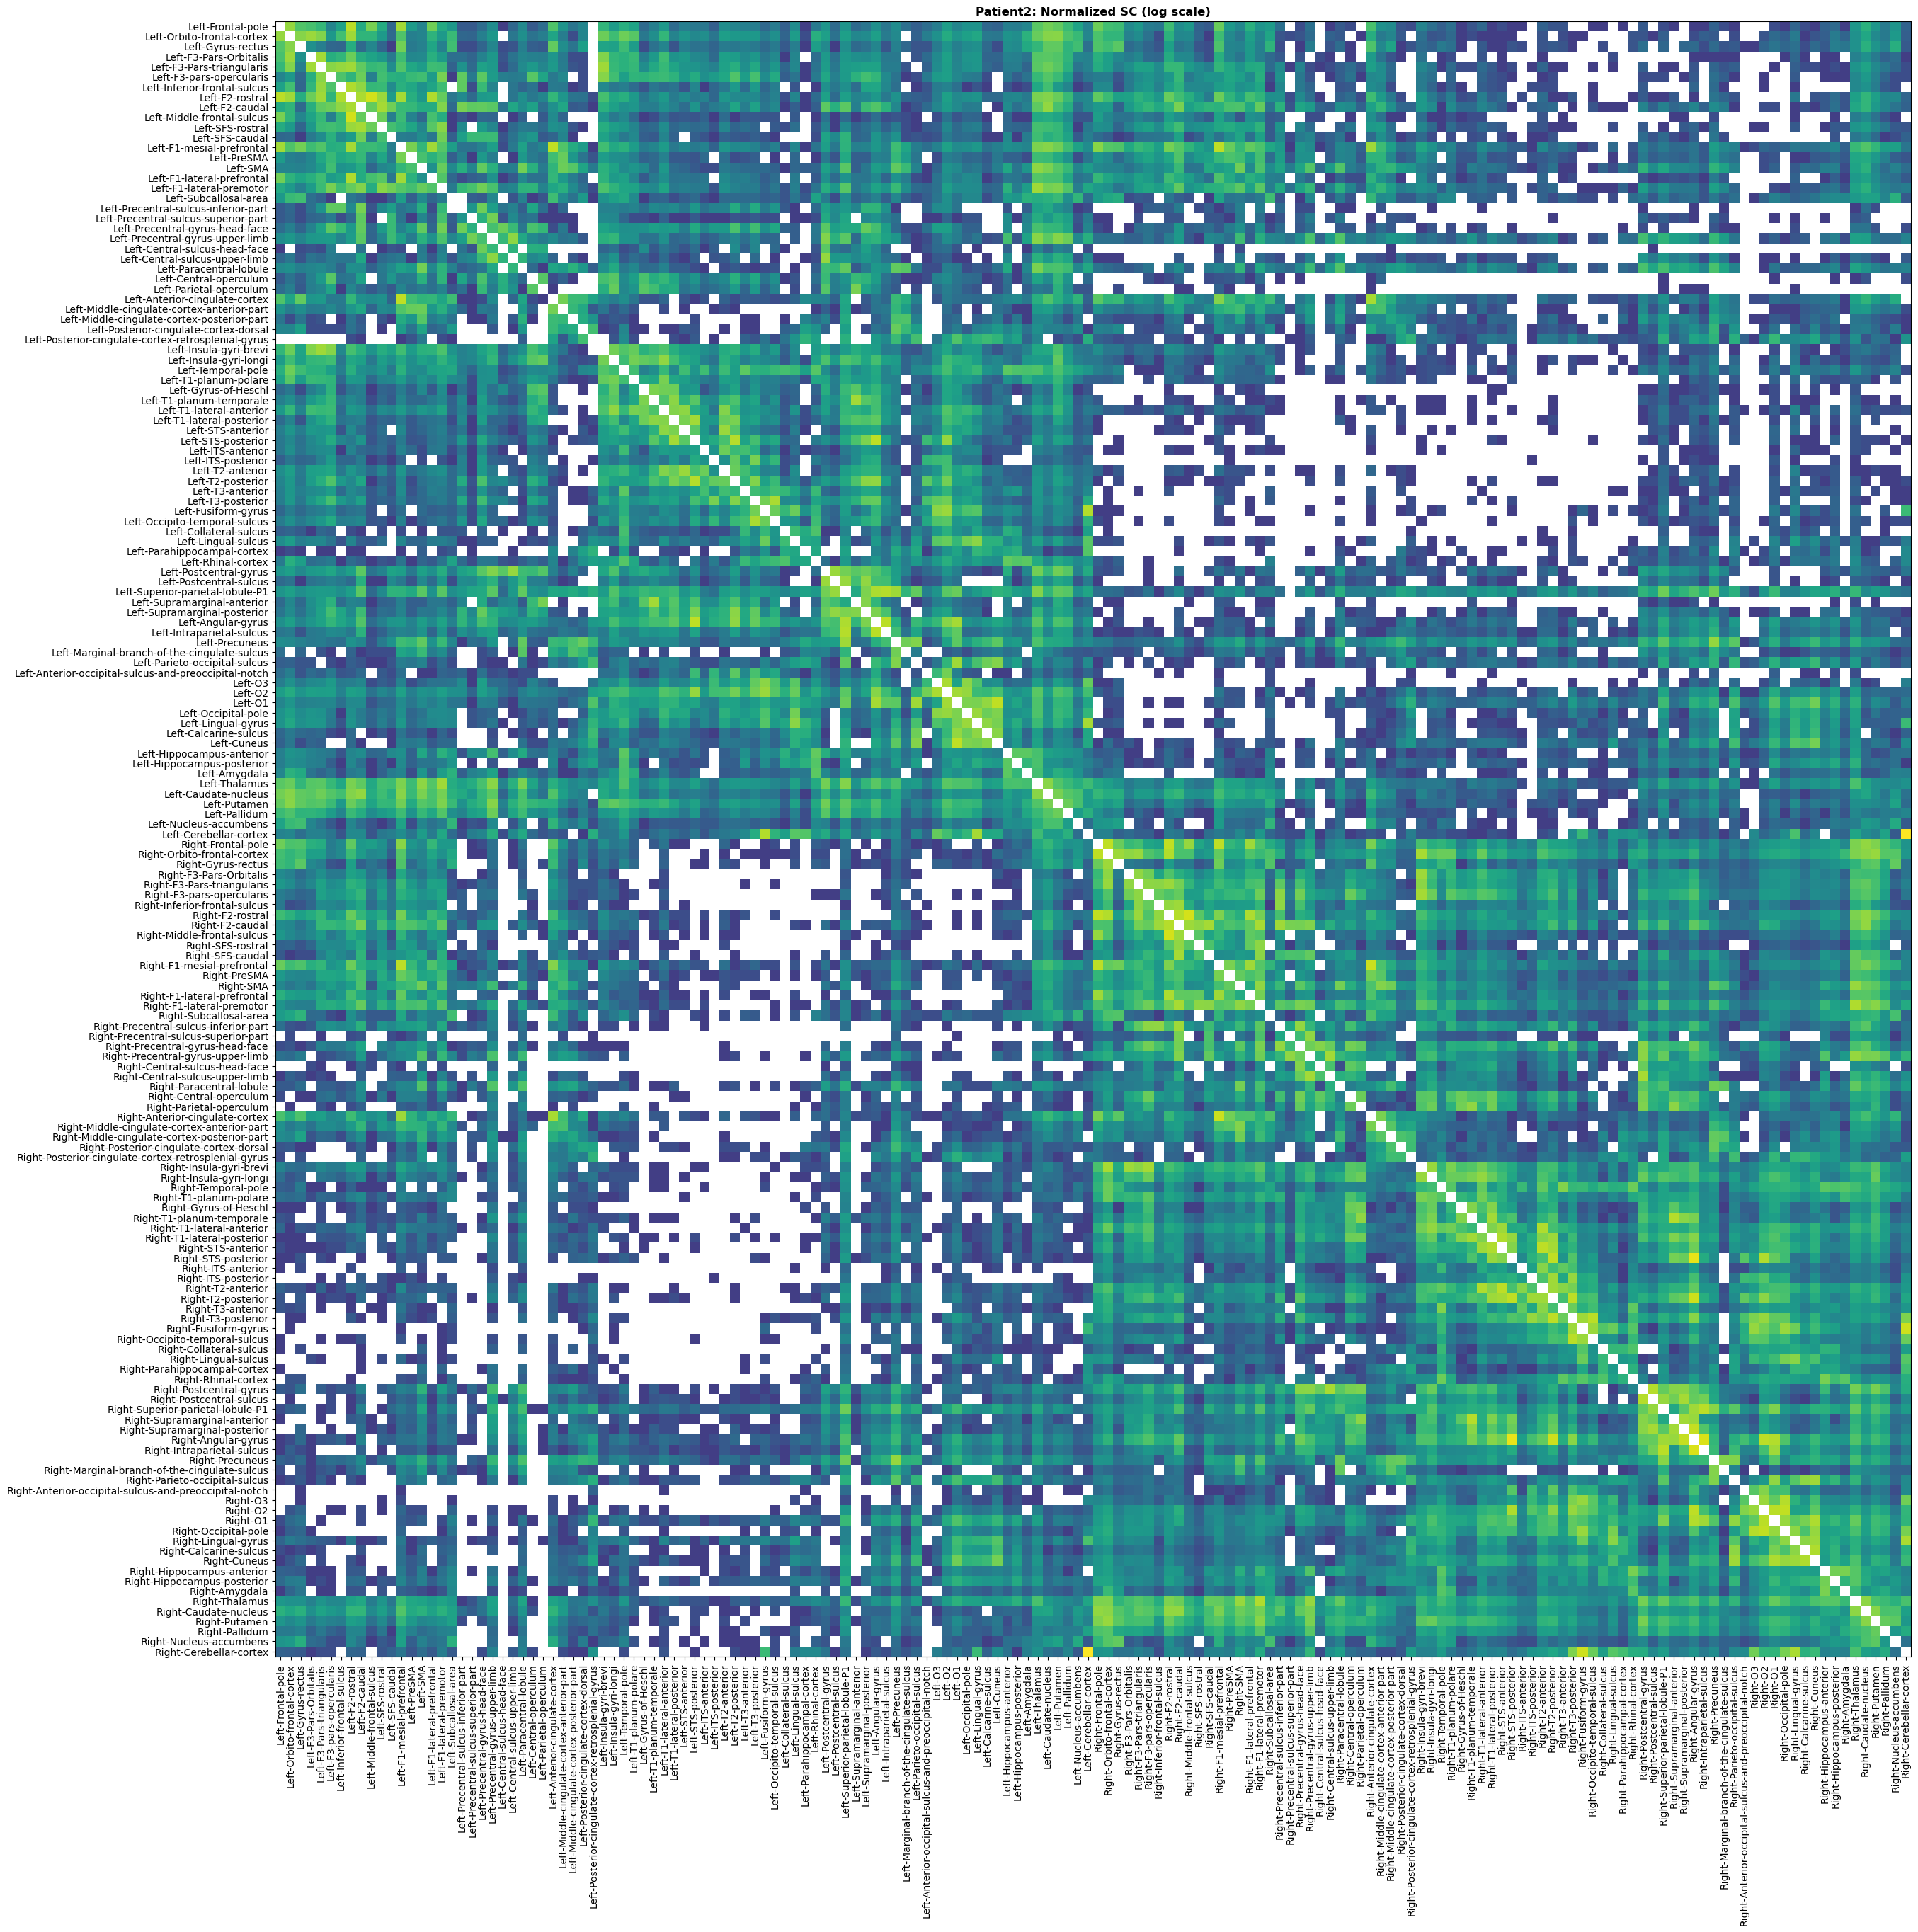

In [32]:
# plot connectivity matrix
save_fname = op.join(results_dir, f'00_{pid}_SC.png')
fig = vep_prepare_op.plot_sc(SC, pid, option='vep_dfs', save_fname=save_fname)

In [35]:
# try to load any previous parameters for this patient
print('>> Load data feature parameters... ', end='', flush=True)
try:
    parameters_1 = vep_prepare.load_data_feature_parameters(pid, fit_id, op.basename(vhdrname_1))
except:
    print('Default parameters')
    scaleplt=0.002
    # usually between 10 and 20
    hpf_1 = hpf_1
    # usually between 0.05 and 0.15
    lpf_1 = lpf_1
    
else:
    print('OK')
    
    scaleplt_1 = parameters_1['scaleplt']
    hpf_1 = parameters_1['hpf']
    lpf_1 = parameters_1['lpf']
   
        
        
print('>> Loaded (or default) parameters:')
print('\thpf:', hpf_1)
print('\tlpf:', lpf_1)


# try to load any previous parameters for this patient
print('>> Load data feature parameters... ', end='', flush=True)
try:
    parameters_2 = vep_prepare.load_data_feature_parameters(pid, fit_id, op.basename(vhdrname_2))
except:
    print('Default parameters')
    scaleplt=0.002
    # usually between 10 and 20
    hpf_2 = hpf_2
    # usually between 0.05 and 0.15
    lpf_2 = lpf_2
    
else:
    print('OK')
    
    scaleplt_2 = parameters_2['scaleplt']
    hpf_2 = parameters_2['hpf']
    lpf_2 = parameters_2['lpf']
   
        
        
print('>> Loaded (or default) parameters:')
print('\thpf:', hpf_2)
print('\tlpf:', lpf_2)


>> Load data feature parameters... Default parameters
>> Loaded (or default) parameters:
	hpf: 4.0
	lpf: 1.0
>> Load data feature parameters... Default parameters
>> Loaded (or default) parameters:
	hpf: 10.0
	lpf: 1.5


## MCMC estimation

### Compute initial values
This steps computes 50 estimations, using stan optimize.\
The 8 best estimations are then selected, based on their likelihood.\
These 8 estimations are used to create initial values for MCMC chains.

In [36]:
stanmodel = 'vep_mm_mcmc'

In [38]:
parallel_jobs_fname = vep_mcmc.create__jobs__optimize__rpne_039(datafeatures_fname=datafeatures_fname,
                                                                stanmodel = stanmodel,
                                                                init_uniform_distribution_range=5,
                                                                n_optimize=n_optimize, n_jobs=n_optimize_jobs, 
                                                                tol_param=1e-10)

>> Save 50 jobs in /results/sampling/Patient2/mcmc/fit_SEEG_multimodal/optimize_vep_mm_mcmc/P2_SEEG_ts_fit.npzP2_SEEG_EEG_fit.npz_SEEG_hpf4.0_lpf1.0_EEG_hpf10.0_lpf1.5/jobs/do_all_local.bash
>> Run: time /usr/bin/parallel -j 50 < /results/sampling/Patient2/mcmc/fit_SEEG_multimodal/optimize_vep_mm_mcmc/P2_SEEG_ts_fit.npzP2_SEEG_EEG_fit.npz_SEEG_hpf4.0_lpf1.0_EEG_hpf10.0_lpf1.5/jobs/do_all_local.bash


## The output of the HMC is approximately 32 GB, Therefore, we have commented out this cell here.
## We have also shared the original Stan code so that you can easily build it on your own machine.

In [19]:

#vep_mcmc.run_jobs_parallel(parallel_jobs_fname=parallel_jobs_fname, n_jobs=n_optimize_jobs)

In [25]:
# read csv files and get the 'lp__'
'''
datafeatures_id = op.basename(datafeatures_fname).rstrip('__datafeatures.R')
output_dir = op.join(op.dirname(op.dirname(datafeatures_fname)),f'optimize_{stanmodel}', datafeatures_id)
logs_dir = op.join(output_dir, 'logs')
csv_dir = op.join(output_dir, 'csv')

lp = np.full(n_optimize, np.nan)
j_ok, j_nok, j_exc = 0, 0, 0

for j in range(n_optimize):
    job_id = f'{datafeatures_id}__j{j}'
    log_fname = op.join(logs_dir, f'{job_id}.log')
    print(f'Reading status from {log_fname}... ', end='', flush=True)
    try:
        status = analyze_fit.analyze_log_file(log_fname)
    except Exception as e:
        print(e)
        j_exc += 1
        continue
    print(status)
    if status == 'ok':
        j_ok += 1
        csv_fname = op.join(csv_dir, f'{job_id}.csv')
        assert op.exists(csv_fname)
        print(f'\t\t>> Reading lp__ from {csv_fname}...', end=' ', flush=True)
        samples = stan.read_samples([csv_fname], variables_of_interest=['lp__'])
        print('ok')
        lp[j] = samples['lp__'][0]
    else:
        j_nok += 1

assert j_ok + j_nok + j_exc == n_optimize
print()
print(f'>> Jobs: {n_optimize}, ok: {j_ok}, nok: {j_nok}, exc: {j_exc}')

sorted_indicies = np.argsort(-lp)
n_best_indices = sorted_indicies[:n_best]

print()
print(f'>> Keeping jobs {n_best_indices} with lp__ {lp[n_best_indices]}')
print()
'''

"\ndatafeatures_id = op.basename(datafeatures_fname).rstrip('__datafeatures.R')\noutput_dir = op.join(op.dirname(op.dirname(datafeatures_fname)),f'optimize_{stanmodel}', datafeatures_id)\nlogs_dir = op.join(output_dir, 'logs')\ncsv_dir = op.join(output_dir, 'csv')\n\nlp = np.full(n_optimize, np.nan)\nj_ok, j_nok, j_exc = 0, 0, 0\n\nfor j in range(n_optimize):\n    job_id = f'{datafeatures_id}__j{j}'\n    log_fname = op.join(logs_dir, f'{job_id}.log')\n    print(f'Reading status from {log_fname}... ', end='', flush=True)\n    try:\n        status = analyze_fit.analyze_log_file(log_fname)\n    except Exception as e:\n        print(e)\n        j_exc += 1\n        continue\n    print(status)\n    if status == 'ok':\n        j_ok += 1\n        csv_fname = op.join(csv_dir, f'{job_id}.csv')\n        assert op.exists(csv_fname)\n        print(f'\t\t>> Reading lp__ from {csv_fname}...', end=' ', flush=True)\n        samples = stan.read_samples([csv_fname], variables_of_interest=['lp__'])\n     

In [26]:
roi = vep_prepare_op.read_vep_mrtrix_lut()
# select the 8 best estimations and create R files containing initial values
'''
vep_mcmc.create__init_files__sample__rpne_039(datafeatures_fname,
                                              stanmodel=stanmodel,
                                              n_optimize=n_optimize, n_best=n_best)
'''

'\nvep_mcmc.create__init_files__sample__rpne_039(datafeatures_fname,\n                                              stanmodel=stanmodel,\n                                              n_optimize=n_optimize, n_best=n_best)\n'

## Run MCMC chains

In [23]:
# create jobs to run MCMC
'''
parallel_jobs_fname = vep_mcmc.create__jobs__sample__rpne_039(datafeatures_fname,
                                                              stanmodel = stanmodel,
                                                              n_init=n_best, 
                                                              n_chains_per_init=n_chains_per_init,
                                                              n_jobs=n_sample_jobs)

vep_mcmc.run_jobs_parallel(parallel_jobs_fname=parallel_jobs_fname, n_jobs=n_sample_jobs)
'''

'\nparallel_jobs_fname = vep_mcmc.create__jobs__sample__rpne_039(datafeatures_fname,\n                                                              stanmodel = stanmodel,\n                                                              n_init=n_best, \n                                                              n_chains_per_init=n_chains_per_init,\n                                                              n_jobs=n_sample_jobs)\n\nvep_mcmc.run_jobs_parallel(parallel_jobs_fname=parallel_jobs_fname, n_jobs=n_sample_jobs)\n'

## Plot MCMC diagnostics

## We've keep the plot here so that you can see what the results looks that. The size of result files to big to generate here.

In [39]:
#chains_status = vep_mcmc.chains_diagnostic(datafeatures_fname,stanmodel=stanmodel)
#print(chains_status)
# We've keep the plot here so that you can see what the results looks that

In [40]:
# write variables of interest to the disk to speed up future usage
# loglikelihood for each chain with status == True to compute their probabilities
'''
chains_indices = np.nonzero(chains_status)[0]
samples = vep_mcmc.extract_samples__variables_of_interest__parfor(datafeatures_fname, 
                                                                  chains_indices,
                                                                  stanmodel=stanmodel,
                                                                  variables_of_interest__csv=['log_lik'],
                                                                  variables_of_interest__npz=['log_lik', 'x0', 'xhat_q', 'x'])
'''

"\nchains_indices = np.nonzero(chains_status)[0]\nsamples = vep_mcmc.extract_samples__variables_of_interest__parfor(datafeatures_fname, \n                                                                  chains_indices,\n                                                                  stanmodel=stanmodel,\n                                                                  variables_of_interest__csv=['log_lik'],\n                                                                  variables_of_interest__npz=['log_lik', 'x0', 'xhat_q', 'x'])\n"

In [41]:
# write the R code to compute the probability of each chain
# input files are csv files containing loglikelihhood
'''
csv__log_lik__fnames = []
datafeatures_id = op.basename(datafeatures_fname).rstrip('__datafeatures.R')
sample_output_dir = op.join(op.dirname(op.dirname(datafeatures_fname)), f'sample_{stanmodel}', datafeatures_id)
csv_dir = op.join(sample_output_dir, 'csv')
k = 'log_lik'
for c in chains_indices:
    job_id = f'{datafeatures_id}__j{c}'
    csv_fname = op.join(csv_dir, f'{job_id}.csv')
    v_fname = csv_fname.replace('.csv', f'__{k}.csv')
    assert op.exists(v_fname)
    csv__log_lik__fnames.append(v_fname)
    
print(csv__log_lik__fnames)
'''

"\ncsv__log_lik__fnames = []\ndatafeatures_id = op.basename(datafeatures_fname).rstrip('__datafeatures.R')\nsample_output_dir = op.join(op.dirname(op.dirname(datafeatures_fname)), f'sample_{stanmodel}', datafeatures_id)\ncsv_dir = op.join(sample_output_dir, 'csv')\nk = 'log_lik'\nfor c in chains_indices:\n    job_id = f'{datafeatures_id}__j{c}'\n    csv_fname = op.join(csv_dir, f'{job_id}.csv')\n    v_fname = csv_fname.replace('.csv', f'__{k}.csv')\n    assert op.exists(v_fname)\n    csv__log_lik__fnames.append(v_fname)\n    \nprint(csv__log_lik__fnames)\n"

# Plot MCMC results, i.e. posterior distributions of x0

In [42]:
'''
hpf=10
lpf=1
chan = np.arange(16)
for ichan  in chan:
    ichain_fname = f'{sample_output_dir}/csv/samples_{ichan}.npz'

    ichain_results = np.load(ichain_fname)

    samples = np.load(ichain_fname, allow_pickle=True)['arr_0'][()]



    x0sam = samples['x0']

    roi = vep_prepare_op.read_vep_mrtrix_lut()

    ijob = n_best_indices[int(ichan/2)]
    csv_fname = f'{output_dir}/csv/{datafeatures_id}__j{ijob}.csv'
    optimal_results = stan.read_samples([csv_fname])

    MAP_results = np.squeeze(optimal_results['x0'])


    #MAP_rload = f'/data/cluster-vep-backup/RetrospectivePatients/1-Processed/id039_mra/mcmc/fit_V1/optimize/MR_C4P_170124b-cex_0028_hpf10_lpf0.04/csv/init/MR_C4P_170124b-cex_0028_hpf10_lpf0.04__j{ijob}_init.R' 

    #MAP_data = stan.rload(MAP_rload)
    #MAP_results = MAP_data['x0_star']

    fig_dir = op.join(csv_dir, 'figures')


    x0sam_min, x0sam_max = np.min(x0sam)-0.2, np.max(x0sam)+0.2
    figsize = (24, 12)
    for i in range(2):
        fig, ax = plt.subplots(figsize=figsize)

        regions_range = range(i*int(162/2), (i+1)*int(162/2))
        ax.violinplot(x0sam[:, regions_range], positions=range(len(regions_range)), showmedians=True)
        ax.set_ylim([x0sam_min, x0sam_max])
        ax.axhline(y=-3.0, color='r', linestyle='--', lw=0.5)
        ax.axhline(y=-2.05, color='r', linestyle='--', lw=0.5)
        ax.axhline(y=-3.9, color='r', linestyle='--', lw=0.5)
        plt.scatter(range(len(regions_range)), MAP_results[regions_range], marker='o', color='red', s=30, zorder=3)

        ax.set_xticks(range(len(regions_range)))
        ax.set_xticklabels([roi[r] for r in regions_range], rotation='vertical')
        fig.suptitle(f'posterior distribution of excitabilities x0_chan_{ichan} ({i+1}/2)')
        fig.tight_layout()

        fname = op.join(fig_dir, f'posterior_x0_part{i+1}_chan_{ichan}.png')
        print(f'Save {fname}')
        fig.savefig(fname)
'''

"\nhpf=10\nlpf=1\nchan = np.arange(16)\nfor ichan  in chan:\n    ichain_fname = f'{sample_output_dir}/csv/samples_{ichan}.npz'\n\n    ichain_results = np.load(ichain_fname)\n\n    samples = np.load(ichain_fname, allow_pickle=True)['arr_0'][()]\n\n\n\n    x0sam = samples['x0']\n\n    roi = vep_prepare_op.read_vep_mrtrix_lut()\n\n    ijob = n_best_indices[int(ichan/2)]\n    csv_fname = f'{output_dir}/csv/{datafeatures_id}__j{ijob}.csv'\n    optimal_results = stan.read_samples([csv_fname])\n\n    MAP_results = np.squeeze(optimal_results['x0'])\n\n\n    #MAP_rload = f'/data/cluster-vep-backup/RetrospectivePatients/1-Processed/id039_mra/mcmc/fit_V1/optimize/MR_C4P_170124b-cex_0028_hpf10_lpf0.04/csv/init/MR_C4P_170124b-cex_0028_hpf10_lpf0.04__j{ijob}_init.R' \n\n    #MAP_data = stan.rload(MAP_rload)\n    #MAP_results = MAP_data['x0_star']\n\n    fig_dir = op.join(csv_dir, 'figures')\n\n\n    x0sam_min, x0sam_max = np.min(x0sam)-0.2, np.max(x0sam)+0.2\n    figsize = (24, 12)\n    for i in ran